In [1]:
import os
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

In [2]:
# ── 0) Your “alphabet” in the exact same order you trained with ───────────────
#    (i.e. the softmax channels 0…C−2 map to these chars; C−1 is the blank)
char_list = [' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
idx_to_char = char_list
blank_id    = len(idx_to_char)    # softmax channel C−1


# ── 1) ONNX‐Runtime session ────────────────────────────────────────────────────
ort_session = ort.InferenceSession(
    "cnn-lstm-ctc (inference only) fp32.onnx",
    providers=["CPUExecutionProvider"]
)

# ── 2) Wrapper around ort_session.run() ───────────────────────────────────────
def onnx_predict(images: np.ndarray) -> np.ndarray:
    """
    images: float32 array of shape [B, H, W, C]
    returns: logits array of shape [B, T, C_out]
    """
    input_name = ort_session.get_inputs()[0].name
    if images.dtype != np.float32:
        images = images.astype(np.float32)
    return ort_session.run(None, {input_name: images})[0]

In [3]:
# ── 3) Pure‐NumPy CTC greedy decode ────────────────────────────────────────────
def decode_batch_predictions_numpy(
    probs: np.ndarray,
    idx_to_char: list[str],
    blank_id: int = None,
    max_len: int = 32
) -> list[str]:
    """
    probs: shape [B, T, C_out] softmax scores
    idx_to_char: list of length C_out−1 mapping class IDs → chars
    blank_id: ID of the CTC blank (defaults to C_out−1)
    """
    B, T, C = probs.shape
    if blank_id is None:
        blank_id = C - 1

    # 1) Greedy best‐path
    best_path = np.argmax(probs, axis=2)  # shape [B, T]

    decoded_texts = []
    for seq in best_path:
        out_chars = []
        prev_id   = None
        for idx in seq:
            # collapse repeats
            if idx == prev_id:
                continue
            prev_id = idx
            # drop blanks
            if idx == blank_id:
                continue
            # map to char
            out_chars.append(idx_to_char[idx])
        decoded_texts.append("".join(out_chars)[:max_len])

    return decoded_texts

# ── 4) Image loader + visualization ──────────────────────────────────────────
def load_images_from_folder(folder, num_images=32, target_size=(256,128)):
    imgs, names = [], []
    for fname in sorted(os.listdir(folder))[:num_images]:
        path = os.path.join(folder, fname)
        im = cv2.imread(path, cv2.IMREAD_COLOR)
        if im is None: continue
        im = cv2.resize(im, target_size)
        im = im.astype("float32") / 255.0
        imgs.append(im)
        names.append(fname)
    return np.stack(imgs, axis=0), names

def visualize_predictions_onnx_from_folder(folder, num_images=12):
    images, filenames = load_images_from_folder(folder, num_images)
    preds  = onnx_predict(images)                             # [B, T, C_out]
    texts  = decode_batch_predictions_numpy(preds, idx_to_char, blank_id)

    rows, cols = 5, 3
    fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
    fig.suptitle("ONNX‑Runtime Predictions", fontsize=18, fontweight='bold')

    for i, (img, txt) in enumerate(zip(images, texts)):
        ax = axes[i // cols, i % cols]
        ax.imshow((img * 255).astype("uint8")[..., ::-1])   # BGR→RGB
        ax.set_title(f"{filenames[i]} --  Pred: {txt}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

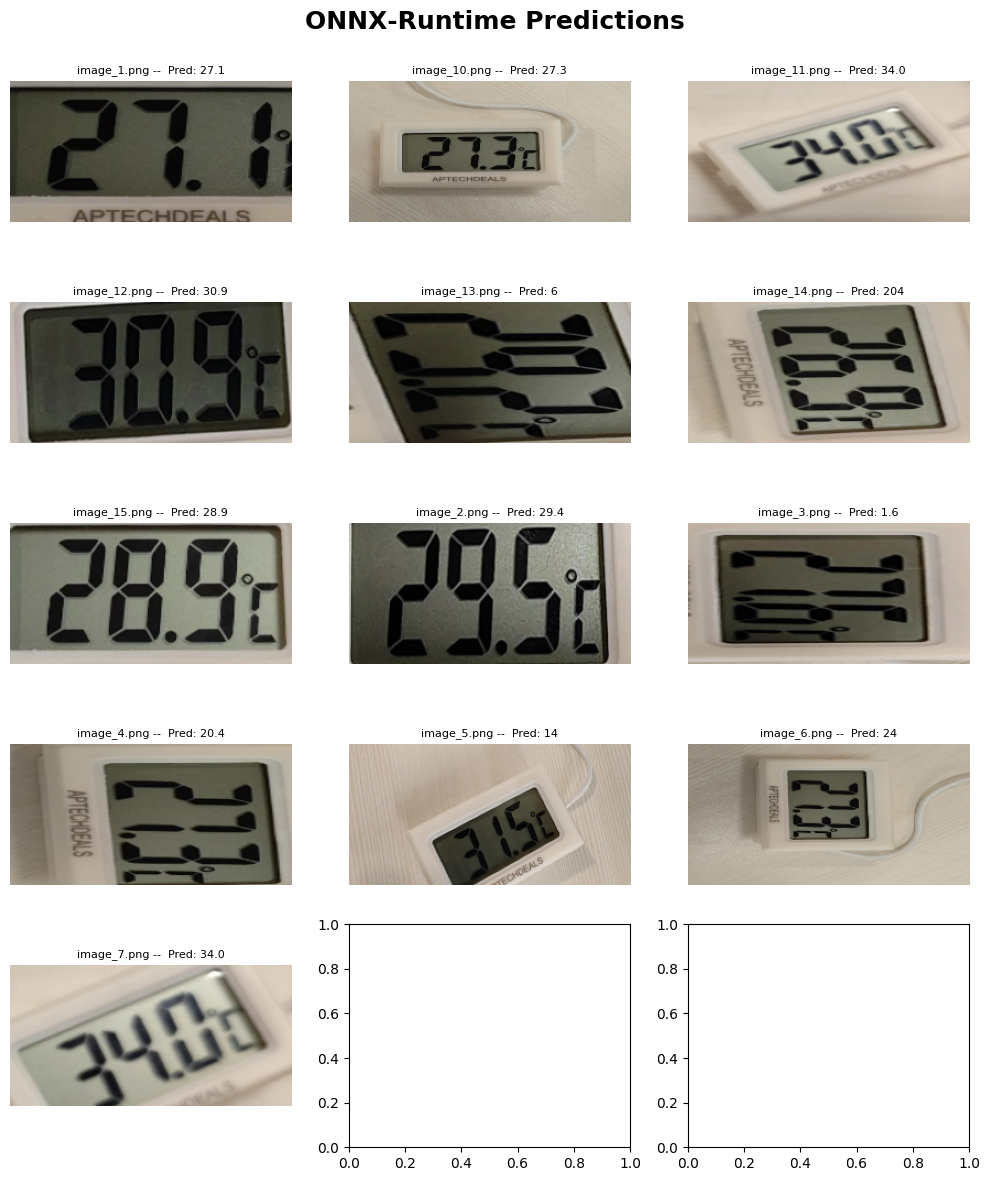

In [4]:
# ── 5) Run it ─────────────────────────────────────────────────────────────────
visualize_predictions_onnx_from_folder("Images/ssd_cropped_images", num_images=15)

Here’s what’s happening, step by step:

1. **Function signature & docstring**  
   ```python
   def decode_batch_predictions_numpy(
       probs: np.ndarray,
       idx_to_char: list[str],
       blank_id: int = None,
       max_len: int = 32
   ) -> list[str]:
   ```
   - **`probs`**: a float array of shape **[B, T, C_out]**, where  
     – B = batch size  
     – T = time steps (the length of your sequence output)  
     – C_out = number of softmax channels (vocabulary size + blank)  
   - **`idx_to_char`**: a Python list mapping class indices `0…C_out-2` → characters.  
   - **`blank_id`**: the index reserved for the CTC “blank” token; if you don’t pass one, it defaults to the last channel `C_out-1`.  
   - **`max_len`**: truncate the decoded string to at most this many characters.

2. **Unpack dimensions & set blank ID**  
   ```python
   B, T, C = probs.shape
   if blank_id is None:
       blank_id = C - 1
   ```
   - Pulls out batch (`B`), time (`T`), and channel count (`C`).  
   - If you didn’t supply `blank_id`, we assume it’s the final channel.

3. **Greedy best‐path selection**  
   ```python
   best_path = np.argmax(probs, axis=2)  # shape [B, T]
   ```
   - At each time step `t`, pick the class with highest probability.  
   - `best_path[b, t]` is the most likely label index for example `b` at time `t`.

4. **Iterate each sequence & collapse repeats**  
   ```python
   decoded_texts = []
   for seq in best_path:
       out_chars = []
       prev_id = None
       for idx in seq:
           # collapse repeats
           if idx == prev_id:
               continue
           prev_id = idx
           …
   ```
   - We walk through each batch’s sequence of indices.  
   - **Collapse repeats**: if the same index appears twice in a row, we skip the second one. This implements the CTC rule that “AAA” produces just “A”.

5. **Drop blanks**  
   ```python
           # drop blanks
           if idx == blank_id:
               continue
   ```
   - Whenever the argmax is the blank token, we don’t emit any character.

6. **Map index → character**  
   ```python
           # map to char
           out_chars.append(idx_to_char[idx])
   ```
   - For every non‑blank, non‑duplicate index, look up its character and append.

7. **Finalize & truncate**  
   ```python
       decoded_texts.append("".join(out_chars)[:max_len])
   return decoded_texts
   ```
   - Join the list of characters into a string.  
   - Optionally clip it to `max_len` (guards against runaway outputs).  
   - Collect all batch strings into `decoded_texts` and return.

---

**In short:**  
- **Argmax** gives you the most likely class at each time step.  
- **Collapse repeats** turns runs of the same label into a single instance.  
- **Drop blanks** removes CTC’s special “no character” symbol.  
- **Map + join** builds the final readable string.